# COMP 484 - Practical Assignment 2

#### Ramraj Chimouriya
#### CE IV/I

## Chapter 2 - Classifying with real world examples

### The Iris Dataset

Iris dataset is a classic dataset from the 1930s. The dataset contains 4 features sepal width, sepal length, petal length and petal width.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Load iris_dataset from sklearn

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

features = data.data
feature_names = data.feature_names

target = data.target
target_names = data.target_names

labels = target_names[target]

Plotting all 2D projections of the features.

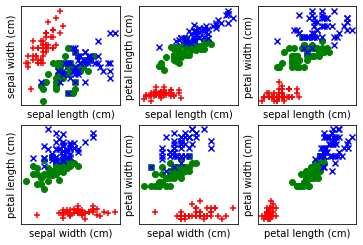

In [3]:
fig, axes = plt.subplots(2,3)
pairs = [(0,1), (0,2), (0, 3), (1, 2), (1, 3), (2, 3)]

color_markers = [
        ('r', '+'),
        ('g', 'o'),
        ('b', 'x'),
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[
                    target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])


### Building first classification model

In [4]:
from sklearn import tree

tr = tree.DecisionTreeClassifier(min_samples_leaf=10)
tr.fit(features, labels)

DecisionTreeClassifier(min_samples_leaf=10)

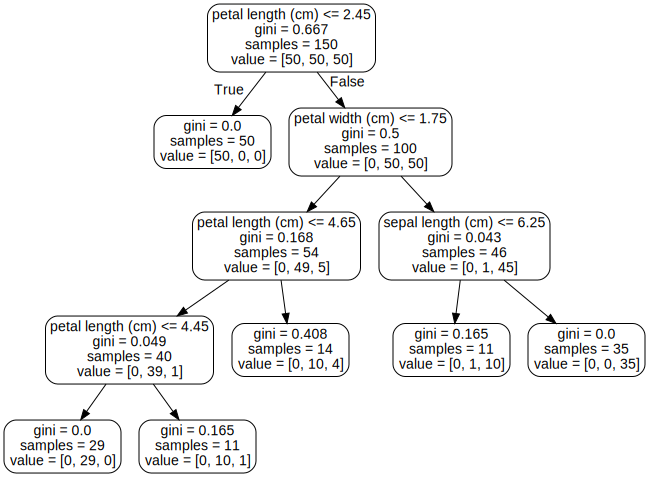

In [6]:
import graphviz
tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file="decision.dot")

graphviz.Source(open("decision.dot").read())

In [8]:
prediction = tr.predict(features)
print(f"Accuracy - {np.mean(prediction==labels) * 100} %")

Accuracy - 96.0 %


Since, we train and evaluate for same data set, the code was optimized for that data set. So, the accuracy is obviously great.

Now, let us split the data aset into two sets, one for training and another data set for testing.

### Evaluation - holding out data and cross validation

Performing leave-one-out cross-validation, where every features in the data set acts as train data except one in which testing is performed. The process is repeated by leaving next data in another iteration and so on. So that, every data set acts as train data as well as test data. 

In [24]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

In [26]:
print(f"Accuracy with leave-one-out cross-validation - {np.mean(predictions.ravel() == labels) * 100} %")

Accuracy with leave-one-out cross-validation - 95.33333333333334 %


Skitlearn provides model for performing cross validation, which can be performed as follows.

In [23]:
from sklearn import model_selection

predictions = model_selection.cross_val_predict(
    tr,
    features,
    labels,
    cv=model_selection.LeaveOneOut()
)

print(np.mean(predictions==labels))

0.9533333333333334
